# LKJ Cholesky Covariance Priors for Multivariate Normal Models¶

#https://docs.pymc.io/notebooks/LKJ.html

In [1]:
import os
import sys
import time

In [2]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt

In [3]:
import theano
import theano.tensor as tt
import pymc3 as pm

In [4]:
theano.config.exception_verbosity = 'high'
os.environ["MKL_THREADING_LAYER"]="GNU"

In [5]:
print('Running on numpy: v{}'.format(np.version.version))
print('Running on theano: v{}'.format(theano.version.version))
print('Running on PYMC3: v{}'.format(pm.__version__))

Running on numpy: v1.18.1
Running on theano: v1.0.4
Running on PYMC3: v3.8


In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
from IPython.display import HTML

In [7]:
%pylab inline

sns.set_style("white")
sns.set_context("talk")

Populating the interactive namespace from numpy and matplotlib


/Users/meysamhashemi/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sci']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
cwd = os.getcwd()
cwd

'/Users/meysamhashemi/WORK/CurrentWork_codes/PPCA'

In [9]:
%matplotlib inline

In [10]:
from matplotlib.patches import Ellipse

In [11]:
import warnings
from warnings import filterwarnings
warnings.filterwarnings('ignore')
filterwarnings('ignore', message='findfont')

In [12]:
N = 100

μ_actual = np.array([1, -2])
Σ_actual = np.array([[0.5, -0.3],
                     [-0.3, 1.]])

x = np.random.multivariate_normal(μ_actual, Σ_actual, size=N)


In [13]:
x.shape

(100, 2)

In [14]:
var, U = np.linalg.eig(Σ_actual)
angle = 180. / np.pi * np.arccos(np.abs(U[0, 0]))

In [15]:
var, U

(array([0.35948752, 1.14051248]),
 array([[-0.90558942,  0.4241554 ],
        [-0.4241554 , -0.90558942]]))

In [16]:
angle

25.097214453867416

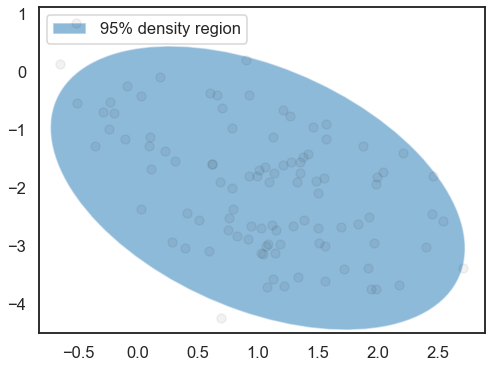

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

blue, _, red, *_ = sns.color_palette()

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.05, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect], ['95% density region'], loc=2);



The sampling distribution for the multivariate normal model is 𝐱∼𝑁(𝜇,Σ), where Σ is the covariance matrix of the sampling distribution (inverse of the precision matrix of the distribution.), with Σ𝑖𝑗=Cov(𝑥𝑖,𝑥𝑗).

The precision matrix is the inverse of the covariance matrix.

The density of this distribution is

$f(\mathbf{x}\ |\ \mu, \Sigma^{-1}) = (2 \pi)^{-\frac{k}{2}} |\Sigma|^{-\frac{1}{2}} \exp\left(-\frac{1}{2} (\mathbf{x} - \mu)^{\top} \Sigma^{-1} (\mathbf{x} - \mu)\right)$.

 LKJ distribution is the set of correlation matrices, not covariance matrices. We will use the separation strategy from Barnard et al. to combine an LKJ prior on the correlation matrix with a prior on the standard deviations of each dimension to produce a prior on the covariance matrix.
The LKJ distribution provides a prior on the correlation matrix, 𝐂=Corr(𝑥𝑖,𝑥𝑗), which, combined with priors on the standard deviations of each component, induces a prior on the covariance matrix, Σ. 
Since inverting Σ is numerically unstable and inefficient, it is computationally advantageous to use the Cholesky decompositon of Σ, Σ=𝐋𝐋⊤, where 𝐋 is a lower-triangular matrix. This decompositon allows computation of the term (𝐱−𝜇)⊤Σ−1(𝐱−𝜇) using back-substitution, which is more numerically stable and efficient than direct matrix inversion.


Let σ be the vector of standard deviations of each component of our normal distribution, and C

be the correlation matrix. The relationship

Σ=diag(σ) Cdiag(σ)

shows that priors on σ
and C will induce a prior on Σ. Following Barnard et al., we place a standard lognormal prior each the elements σ, and an LKJ prior on the correlation matric C. The LKJ distribution requires a shape parameter 𝜂>0. If C∼LKJ(𝜂), then f(C)∝|C|𝜂−1 (here |⋅| is the determinant).


PyMC3 supports LKJ priors for the Cholesky decomposition of the covariance matrix via the LKJCholeskyCov distribution. This distribution has parameters n and sd_dist, which are the dimension of the observations, 𝐱, and the PyMC3 distribution of the component standard deviations, repsectively. It also has a hyperparamter eta, which controls the amount of correlation between components of 𝐱. The LKJ distribution has the density 𝑓(𝐂 | 𝜂)∝|𝐂|𝜂−1, so 𝜂=1 leads to a uniform distribution on correlation matrices, while the magnitude of correlations between components decreases as 𝜂→∞.

In this example, we model the standard deviations with HalfCauchy(2.5)
priors, and the correlation matrix as 𝐂∼LKJ(𝜂=2).

In [24]:
with pm.Model() as model:
    packed_L = pm.LKJCholeskyCov('packed_L', n=2,
                                 eta=2., sd_dist=pm.HalfCauchy.dist(2.5))

In [25]:
packed_L.tag.test_value.shape

(3,)

In [26]:
with model:
    L = pm.expand_packed_triangular(2, packed_L)
    Σ = pm.Deterministic('Σ', L.dot(L.T))

In [27]:
L.tag.test_value.shape

(2, 2)

In [28]:
with model:
    μ = pm.Normal('μ', 0., 10., shape=2, testval=x.mean(axis=0))
    obs = pm.MvNormal('obs', μ, chol=L, observed=x)

In [30]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(draws=2000, tune=2000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [μ]
>Metropolis: [packed_L]
Sampling 2 chains, 0 divergences: 100%|██████████| 8000/8000 [00:03<00:00, 2142.16draws/s]
The number of effective samples is smaller than 10% for some parameters.


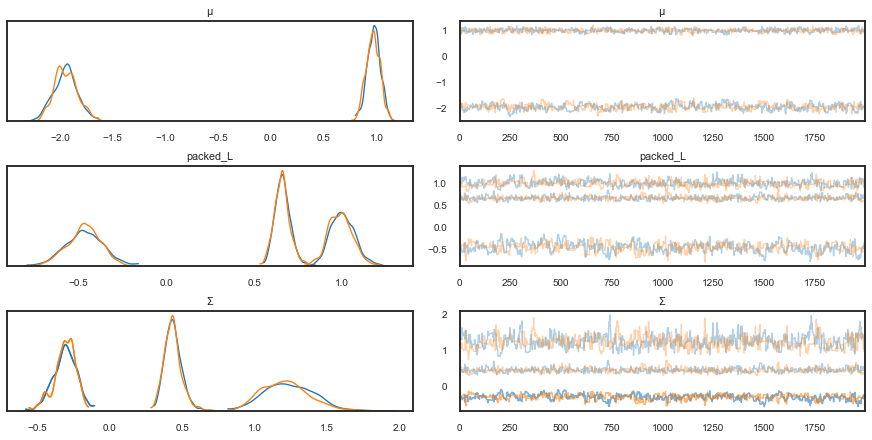

In [31]:
pm.traceplot(trace);

In [39]:
μ_actual

array([ 1, -2])

In [40]:
μ_post = trace['μ'].mean(axis=0)
μ_post

array([ 0.97144229, -1.94551608])

In [41]:
1 - μ_post / μ_actual

array([0.02855771, 0.02724196])

In [42]:
Σ_actual

array([[ 0.5, -0.3],
       [-0.3,  1. ]])

In [43]:
Σ_post = trace['Σ'].mean(axis=0)
Σ_post

array([[ 0.43751203, -0.3111662 ],
       [-0.3111662 ,  1.22940457]])

In [44]:
1 - Σ_post / Σ_actual

array([[ 0.12497595, -0.03722067],
       [-0.03722067, -0.22940457]])

In [45]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

In [46]:
sd_actual = np.sqrt(np.diag(Σ_actual))
corr_actual = np.diag(sd_actual**-1).dot(Σ_actual.dot(np.diag(sd_actual**-1)))
corr_actual

array([[ 1.        , -0.42426407],
       [-0.42426407,  1.        ]])

In [47]:
sd_post = np.sqrt(np.diag(Σ_post))
corr_post = np.diag(sd_post**-1).dot(Σ_post.dot(np.diag(sd_post**-1)))
corr_post

array([[ 1.       , -0.4242775],
       [-0.4242775,  1.       ]])

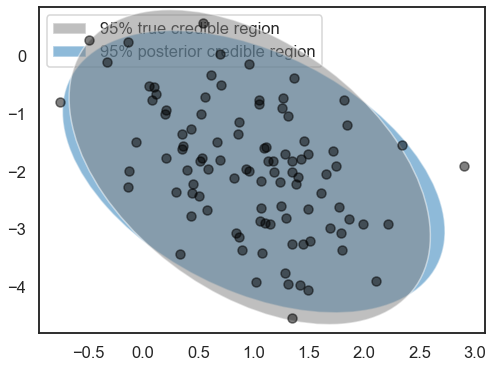

In [98]:
fig, ax = plt.subplots(figsize=(8, 6))

e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)
e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

e_post = Ellipse(μ_post, 2 * np.sqrt(5.991 * var_post[0]),
                 2 * np.sqrt(5.991 * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor('gray')
e_post.set_zorder(10);
ax.add_artist(e_post);

ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
post_rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect, post_rect],
          ['95% true credible region',
           '95% posterior credible region'],
          loc=2);
# ax.set_xlim(-4, 4)
# plt.show()

Another 

In [49]:
with pm.Model() as model:
    sigma = pm.Lognormal('sigma', np.zeros(2), np.ones(2), shape=2)
    
    nu = pm.Uniform('nu', 0, 5)
    C_triu = pm.LKJCorr('C_triu', nu, 2) 

There is a slight complication in pymc3’s handling of the LKJCorr distribution; pymc3 represents the support of this distribution as a one-dimensional vector of the upper triangular elements of the full covariance matrix.

In [50]:
C_triu.tag.test_value.shape

(1,)

In order to build a the full correlation matric C, we first build a 2×2 tensor whose values are all C_triu and then set the diagonal entries to one. (Recall that a correlation matrix must be symmetric and positive definite with all diagonal entries equal to one.) We can then proceed to build the covariance matrix Σ and the precision matrix Λ.

In [51]:
with model:
    C = pm.Deterministic('C', tt.fill_diagonal(C_triu[np.zeros((2, 2), dtype=np.int64)], 1.))
    
    sigma_diag = pm.Deterministic('sigma_mat', tt.nlinalg.diag(sigma))
    cov = pm.Deterministic('cov', tt.nlinalg.matrix_dot(sigma_diag, C, sigma_diag))
    tau = pm.Deterministic('tau', tt.nlinalg.matrix_inverse(cov))

While defining C in terms of C_triu was simple in this case because our sampling distribution is two-dimensional, the example from this StackOverflow question shows how to generalize this transformation to arbitrarily many dimensions.

Finally, we define the prior on μ
and the sampling distribution.

In [52]:
with model:
    mu = pm.MvNormal('mu', 0, tau, shape=2, testval=x.mean(axis=0))
    
    x_ = pm.MvNormal('x', mu, tau, observed=x)

In [54]:
with model:
    step = pm.NUTS()
    trace = pm.sample(draws=2000, tune=2000, step=step)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, C_triu, nu, sigma]
Sampling 2 chains, 1,661 divergences: 100%|██████████| 8000/8000 [04:29<00:00, 29.69draws/s]
There were 875 divergences after tuning. Increase `target_accept` or reparameterize.
There were 785 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


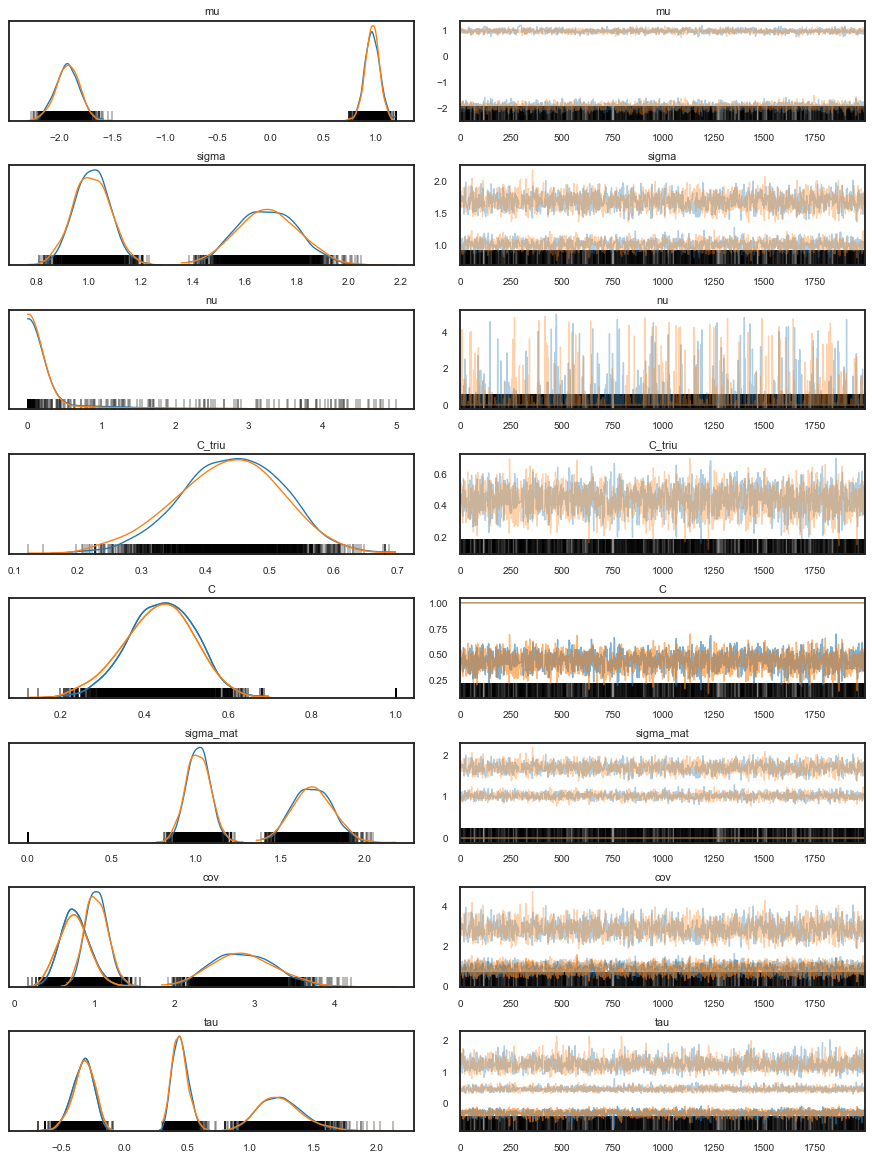

In [55]:
pm.traceplot(trace);

In [87]:
μ_post = trace['mu'].mean(axis=0)
μ_post

array([ 0.96390678, -1.92244016])

In [59]:
1 - μ_post / μ_actual

array([0.03609322, 0.03877992])

In [60]:
Σ_actual

array([[ 0.5, -0.3],
       [-0.3,  1. ]])

In [64]:
Σ_post = trace['tau'].mean(axis=0)
Σ_post

array([[ 0.44581472, -0.3268812 ],
       [-0.3268812 ,  1.24384763]])

In [66]:
1 - Σ_post / Σ_actual

array([[ 0.10837057, -0.08960399],
       [-0.08960399, -0.24384763]])

In [68]:
var_post, U_post = np.linalg.eig(Σ_post)
angle_post = 180. / np.pi * np.arccos(np.abs(U_post[0, 0]))

In [69]:
sd_actual = np.sqrt(np.diag(Σ_actual))
corr_actual = np.diag(sd_actual**-1).dot(Σ_actual.dot(np.diag(sd_actual**-1)))
corr_actual

array([[ 1.        , -0.42426407],
       [-0.42426407,  1.        ]])

In [70]:
sd_post = np.sqrt(np.diag(Σ_post))
corr_post = np.diag(sd_post**-1).dot(Σ_post.dot(np.diag(sd_post**-1)))
corr_post

array([[ 1.        , -0.43896425],
       [-0.43896425,  1.        ]])

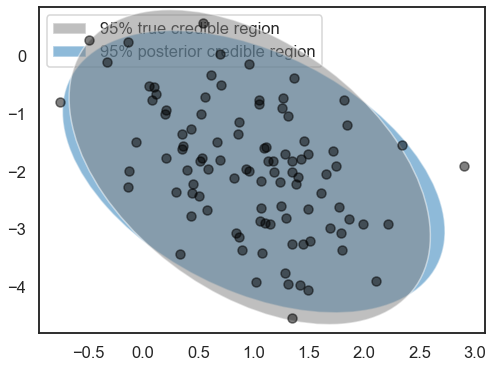

In [97]:
fig, ax = plt.subplots(figsize=(8, 6))

blue = sns.color_palette()[0]


e = Ellipse(μ_actual, 2 * np.sqrt(5.991 * var[0]),
            2 * np.sqrt(5.991 * var[1]),
            angle=angle)

e.set_alpha(0.5)
e.set_facecolor(blue)
e.set_zorder(10);
ax.add_artist(e);

e_post = Ellipse(μ_post, 2 * np.sqrt(5.991 * var_post[0]),
                 2 * np.sqrt(5.991 * var_post[1]),
                 angle=angle_post)
e_post.set_alpha(0.5)
e_post.set_facecolor('gray')
e_post.set_zorder(10);
ax.add_artist(e_post);



ax.scatter(x[:, 0], x[:, 1], c='k', alpha=0.5, zorder=11);

rect = plt.Rectangle((0, 0), 1, 1, fc='gray', alpha=0.5)
post_rect = plt.Rectangle((0, 0), 1, 1, fc=blue, alpha=0.5)
ax.legend([rect, post_rect],
          ['95% true credible region',
           '95% posterior credible region'],
          loc=2);
# ax.set_xlim(-4, 4)
# plt.show()